# Setup

In [1]:
# Catch warnings
import warnings

# Data manipulation
import pandas as pd
import numpy as np
from numpy import (sort, mean, std, argmax, arange)

# Data visualization
import matplotlib.pyplot as plt
# from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid")

# Model setup
import random
from collections import Counter

# Model pipelines and preprocessing
import imblearn
import sklearn
from sklearn import set_config
from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
from sklearn.compose import (make_column_transformer, ColumnTransformer, make_column_selector)
from sklearn.preprocessing import (StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder)

set_config(display="diagram")  # make pipeline visible

# Feature selection
from sklearn.feature_selection import VarianceThreshold

# Model development
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
# import xgboost as xgb
from xgboost import XGBClassifier

# Data resampling
from imblearn.over_sampling import (RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN)

# Model selection and evaluation
from sklearn.model_selection import (train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV)
from yellowbrick.classifier import (ConfusionMatrix, DiscriminationThreshold)
from sklego.meta import Thresholder
from sklearn.metrics import (make_scorer, fbeta_score, confusion_matrix, 
                             classification_report, f1_score) #precision_recall_curve, 
# from sklearn.calibration import (CalibratedClassifierCV, calibration_curve)

# Save model
import joblib

# Custom package
import tools_repo as tr

# Set notebook options
pd.set_option("display.max_columns", 150)
pd.set_option("display.max_rows", 10000)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

# Pretty display of multiple functions in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set random state
RANDOM_STATE = 2021

C:\Users\yvett\anaconda3\envs\employee-attrition-python\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# File Location

In [2]:
# file paths
INTERIM_FILEPATH = '../data/interim/'
FIGURE_PATH = '../reports/figures/'
MODELS_PATH = '../models/'

INTERIM_FILENAME_V2 = 'employee_churn_data_v2'

# Load Data 

In [3]:
master = pd.read_csv(INTERIM_FILEPATH + INTERIM_FILENAME_V2 + '.csv')
# master.info()

In [4]:
master.shape; master.head(2)

(9540, 15)

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left,satisfaction.group3,review.group3,avg_hrs_month.group3,left_num,counter
0,operations,0,0.58,3,low,5.00,0.63,0,180.87,no,passives,subpar performers,short-hour workers,0,1
1,operations,0,0.75,3,medium,6.00,0.44,0,182.71,no,detractors,high performers,short-hour workers,0,1


# Define Metric of Interest

The F2-measure is an example of the Fbeta-measure with a beta value of 2.0.

It has the effect of lowering the importance of precision and increase the importance of recall.

If maximizing precision minimizes false positives, and maximizing recall minimizes false negatives, then the F2-measure puts more attention on minimizing false negatives than minimizing false positives.

In [5]:
# calculate f2 score
def f2(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)
 
# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation the metric
    metric = make_scorer(f2)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# Minimal Data Prep

## convert data types

In [6]:
master_sub3 = master.copy()

In [7]:
master_sub3.dtypes

department               object
promoted                  int64
review                  float64
projects                  int64
salary                   object
tenure                  float64
satisfaction            float64
bonus                     int64
avg_hrs_month           float64
left                     object
satisfaction.group3      object
review.group3            object
avg_hrs_month.group3     object
left_num                  int64
counter                   int64
dtype: object

In [8]:
# master_sub3.describe().transpose()

In [9]:
cat = ['department', 'promoted',  'projects', 'salary', 'tenure', 'bonus',  'satisfaction.group3', 'review.group3', 'avg_hrs_month.group3']

In [10]:
num = ['review', 'satisfaction', 'avg_hrs_month']

In [11]:
def convert_dtypes(df, cat, num):
    for col in df.columns:
        if col in cat:
            df[col]=df[col].astype(str)
        
        elif col in num:
            df[col]=df[col].astype('float64')

        else:
            df[col]=df[col]
            
    return df

In [12]:
master_sub4 = convert_dtypes(master_sub3, cat, num)

In [13]:
master_sub4.dtypes

department               object
promoted                 object
review                  float64
projects                 object
salary                   object
tenure                   object
satisfaction            float64
bonus                    object
avg_hrs_month           float64
left                     object
satisfaction.group3      object
review.group3            object
avg_hrs_month.group3     object
left_num                  int64
counter                   int64
dtype: object

## subset data by data type

In [14]:
print(list(master_sub4))

['department', 'promoted', 'review', 'projects', 'salary', 'tenure', 'satisfaction', 'bonus', 'avg_hrs_month', 'left', 'satisfaction.group3', 'review.group3', 'avg_hrs_month.group3', 'left_num', 'counter']


In [15]:
input_features = ['department', 'promoted', 'review', 'projects', 'salary', 'tenure', 'satisfaction', 'bonus', 'avg_hrs_month', 'satisfaction.group3', 'review.group3', 'avg_hrs_month.group3']
target = ['left']

In [16]:
X_raw = master_sub4[input_features]

In [17]:
X = X_raw.copy(); X_raw.shape

(9540, 12)

In [18]:
feature_names = X.columns.to_list()

In [19]:
cat_cols = list(X.select_dtypes(include=['object']).columns); len(cat_cols); print(cat_cols)

9

['department', 'promoted', 'projects', 'salary', 'tenure', 'bonus', 'satisfaction.group3', 'review.group3', 'avg_hrs_month.group3']


In [20]:
num_cols = list(set(X.columns).difference(set(cat_cols))); len(num_cols); print(num_cols)

3

['review', 'satisfaction', 'avg_hrs_month']


In [21]:
y_raw = master_sub4[target]

## preprocess target variable

In [22]:
# label encode the target variable to have the classes 0 and 1
y = LabelEncoder().fit_transform(y_raw.values.ravel())

## preprocess features

In [23]:
# preprocess features
ordinal_features=['promoted', 'projects', 'salary', 'bonus', 'tenure', 'satisfaction.group3', 'review.group3']
ordinal_orders=[ 
    #promoted 
['0', '1'], 
    #projects 
['2', '3', '4', '5'], 
    #salary
['low', 'medium', 'high'],
    #bonus 
['0', '1'], 
    #tenure 
['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], 
    #satisfaction.group3 
['detractors', 'passives', 'promoters'], 
    #review.group3 
['subpar performers', 'solid performers', 'high performers'],
]
ordinal_transformer = OrdinalEncoder(categories= ordinal_orders, handle_unknown='use_encoded_value', unknown_value=-1)

nominal_features = ['department', 'avg_hrs_month.group3']
nominal_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ordinal_features),
        ('nom', nominal_transformer, nominal_features),
    ], remainder='passthrough'
) 

# Model Selection

## baseline model

In [24]:
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))

# define the reference model
model = DummyClassifier(strategy='constant', constant=1)

# define pipeline
pipe0 = Pipeline(steps=[('p', preprocessor), ('m', model)])

# evaluate the model
scores = evaluate_model(X, y, pipe0)

# summarize performance
print('Mean F2: %.3f ± %.3f' % (np.mean(scores), std(scores)))

(9540, 12) (9540,) Counter({0: 6756, 1: 2784})
Mean F2: 0.673 ± 0.001


## evaluate / spot-check ML algorithms

### without preprocessing numerical variables

>LR 0.628 ± 0.019
>LSVC 0.243 ± 0.314
>CART 0.692 ± 0.018
>KNN 0.681 ± 0.028
>BAG 0.729 ± 0.019
>ADA 0.472 ± 0.024
>GBC 0.712 ± 0.021
>XGB 0.728 ± 0.023
>RF 0.709 ± 0.024
>ET 0.684 ± 0.024


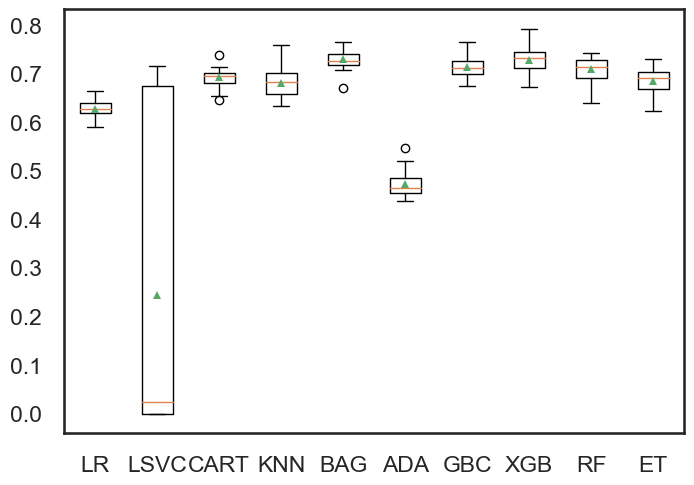

In [25]:
# define models to test
def get_models():
    models, names = list(), list()
    
    #linear models
    # Logistic' 
    models.append(LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE))
    names.append('LR')
    # LinearSVC' 
    models.append(LinearSVC(random_state=RANDOM_STATE))
    names.append('LSVC')

    #non-linear models
    # CART
    models.append(DecisionTreeClassifier(random_state=RANDOM_STATE))
    names.append('CART')
    # KNN
    models.append(KNeighborsClassifier())
    names.append('KNN')
    
    #ensemble models
    # Bagging
    models.append(BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=RANDOM_STATE))
    names.append('BAG')
    # Adaboost
    models.append(AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE))
    names.append('ADA')
    # Gradient Boosting
    models.append(GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE))
    names.append('GBC')
    # XGBoost
    models.append(XGBClassifier(n_estimators=100, random_state=RANDOM_STATE))
    names.append('XGB')
    # RF
    models.append(RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE))
    names.append('RF')
    # ET
    models.append(ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_STATE))
    names.append('ET')
    return models, names

# define models
models, names = get_models()
results = list()

# evaluate each model
for i in range(len(models)):
    # wrap the model i a pipeline
    pipeline = Pipeline(steps=[('p', preprocessor),('m',models[i])])
    
    # evaluate the model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    
    # summarize and store
    print('>%s %.3f ± %.3f' % (names[i], np.mean(scores), std(scores)))
    
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show();

### with preprocessing numerical variables

>LR 0.628 ± 0.018
>LSVC 0.326 ± 0.028
>CART 0.691 ± 0.017
>KNN 0.665 ± 0.025
>BAG 0.730 ± 0.020
>ADA 0.471 ± 0.024
>GBC 0.713 ± 0.022
>XGB 0.730 ± 0.021
>RF 0.710 ± 0.023
>ET 0.678 ± 0.021


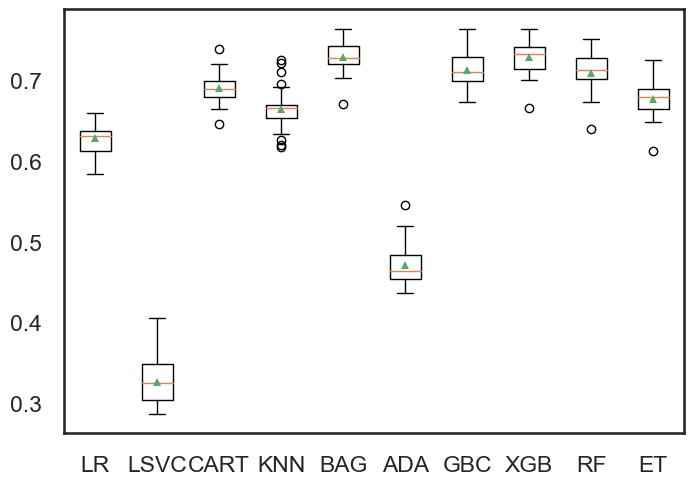

In [26]:
# define models to test
def get_models():
    models, names = list(), list()
    
    #linear models
    # Logistic' 
    models.append(LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE))
    names.append('LR')
    # LinearSVC' 
    models.append(LinearSVC(random_state=RANDOM_STATE))
    names.append('LSVC')

    #non-linear models
    # CART
    models.append(DecisionTreeClassifier(random_state=RANDOM_STATE))
    names.append('CART')
    # KNN
    models.append(KNeighborsClassifier())
    names.append('KNN')
    
    #ensemble models
    # Bagging
    models.append(BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=RANDOM_STATE))
    names.append('BAG')
    # Adaboost
    models.append(AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE))
    names.append('ADA')
    # Gradient Boosting
    models.append(GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE))
    names.append('GBC')
    # XGBoost
    models.append(XGBClassifier(n_estimators=100, random_state=RANDOM_STATE))
    names.append('XGB')
    # RF
    models.append(RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE))
    names.append('RF')
    # ET
    models.append(ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_STATE))
    names.append('ET')
    return models, names


# numerical features indices
num_ix = [2, 6, 8]

# define models
models, names = get_models()
results = list()

# evaluate each model
for i in range(len(models)):
    
    # standardize numerical
    ct = ColumnTransformer([('num', StandardScaler(), num_ix),        
                            ('ord', ordinal_transformer, ordinal_features),
                            ('nom', nominal_transformer, nominal_features),
    ], remainder='passthrough')
    
    # wrap the model i a pipeline
    pipeline = Pipeline(steps=[('t',ct),('m',models[i])])
    
    # evaluate the model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    
    # summarize and store
    print('>%s %.3f ± %.3f' % (names[i], np.mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show();

## evaluate data oversampling algorithms

>ROS 0.760 ± 0.019
>SMOTE 0.777 ± 0.019
>BLSMOTE 0.787 ± 0.021
>SVMSMOTE 0.791 ± 0.019
>ADASYN 0.787 ± 0.021


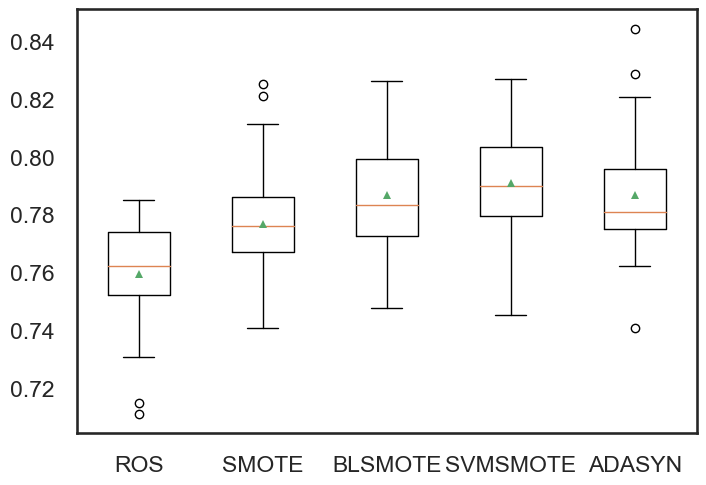

In [27]:
# define oversampling models to test
def get_models():
    models, names = list(), list()
    # RandomOverSampler
    models.append(RandomOverSampler(random_state=RANDOM_STATE))
    names.append('ROS')
    # SMOTE
    models.append(SMOTE(random_state=RANDOM_STATE))
    names.append('SMOTE')
    # BorderlineSMOTE
    models.append(BorderlineSMOTE(random_state=RANDOM_STATE))
    names.append('BLSMOTE')
    # SVMSMOTE
    models.append(SVMSMOTE(random_state=RANDOM_STATE))
    names.append('SVMSMOTE')
    # ADASYN
    models.append(ADASYN(random_state=RANDOM_STATE))
    names.append('ADASYN')
    return models, names


num_ix = [2, 6, 8]

# define models
models, names = get_models()
results = list()

# evaluate each model
for i in range(len(models)):
    
    # define the model
    model = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=RANDOM_STATE)
    
        
    # standardize numerical
    ct = ColumnTransformer([('num', StandardScaler(), num_ix),        
                            ('ord', ordinal_transformer, ordinal_features),
                            ('nom', nominal_transformer, nominal_features),
    ], remainder='passthrough')
    
    # define the pipeline steps
    pipeline = sklearn.pipeline.Pipeline([
    ('t',ct),
    ('pipeline', imblearn.pipeline.Pipeline([
    ('o', models[i]), 
      ('m', model)
  ]))
])
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    # summarize and store
    print('>%s %.3f ± %.3f' % (names[i], np.mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show();

# Model Optimization

## split data into train/test split

In [28]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE)
X_test.shape; X_train.shape

(3149, 12)

(6391, 12)

## preprocessing + feature selection + resampling + hyperparameter tuning

In [29]:
# define model
model = BaggingClassifier(DecisionTreeClassifier(), random_state=RANDOM_STATE)

# numerical features indices
num_ix = [2, 6, 8]

# preprocess features
ordinal_features=['promoted', 'projects', 'salary', 'bonus', 'tenure', 'satisfaction.group3', 'review.group3']
ordinal_orders=[ 
    #promoted 
['0', '1'], 
    #projects 
['2', '3', '4', '5'], 
    #salary
['low', 'medium', 'high'],
    #bonus 
['0', '1'], 
    #tenure 
['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], 
    #satisfaction.group3 
['detractors', 'passives', 'promoters'], 
    #review.group3 
['subpar performers', 'solid performers', 'high performers'],
]
ordinal_transformer = OrdinalEncoder(categories= ordinal_orders, handle_unknown='use_encoded_value', unknown_value=-1)

nominal_features = ['department', 'avg_hrs_month.group3']
nominal_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_ix), 
        ('ord', ordinal_transformer, ordinal_features),
        ('nom', nominal_transformer, nominal_features),
    ], remainder='passthrough'
) 

resample = SVMSMOTE(random_state=RANDOM_STATE)

# define pipeline
pipe = imblearn.pipeline.Pipeline([
    ('p', preprocessor),('selector', VarianceThreshold()),
    ('r', resample), 
      ('m', model)
  ])


parameters = {
 'selector__threshold':[0, 0.001, 0.01],
 'm__n_estimators': [10, 100, 1000]
}

# define parameters
threshold =  [0, 0.001, 0.01]
n_estimators = [10, 100, 1000]


# define grid search
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
metric = make_scorer(f2)
grid_search = GridSearchCV(estimator=pipe, param_grid=parameters, n_jobs=-1, cv=cv, scoring=metric,error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f ± %f with: %r" % (mean, stdev, param))

Best: 0.787846 using {'m__n_estimators': 1000, 'selector__threshold': 0}
0.766767 ± 0.021015 with: {'m__n_estimators': 10, 'selector__threshold': 0}
0.766767 ± 0.021015 with: {'m__n_estimators': 10, 'selector__threshold': 0.001}
0.766767 ± 0.021015 with: {'m__n_estimators': 10, 'selector__threshold': 0.01}
0.786705 ± 0.021349 with: {'m__n_estimators': 100, 'selector__threshold': 0}
0.786705 ± 0.021349 with: {'m__n_estimators': 100, 'selector__threshold': 0.001}
0.786705 ± 0.021349 with: {'m__n_estimators': 100, 'selector__threshold': 0.01}
0.787846 ± 0.021411 with: {'m__n_estimators': 1000, 'selector__threshold': 0}
0.787846 ± 0.021411 with: {'m__n_estimators': 1000, 'selector__threshold': 0.001}
0.787846 ± 0.021411 with: {'m__n_estimators': 1000, 'selector__threshold': 0.01}


In [30]:
# initialize the model with the best estimor
best_model = grid_result.best_estimator_

# Predict the model with the pca testing dataset
y_pred = best_model.predict(X_test)

# #get the predict probablities of pca testing dataset
# y_pred_proba = best_model.predict_proba(X_test)

In [31]:
targ_names = ['stayed (0)', 'left (1)']

In [32]:
# Classification Report
print('\nClassification Report (Before Threshold Moving) : \n\n', classification_report(y_test, y_pred, target_names=targ_names, digits=3))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

# Model evaluation
scores = evaluate_model(X_test, y_test, best_model)
# summarize performance
print('Mean F2: %.3f ± %.3f' % (np.mean(scores), std(scores)))


Classification Report (Before Threshold Moving) : 

               precision    recall  f1-score   support

  stayed (0)      0.918     0.868     0.892      2244
    left (1)      0.712     0.808     0.757       905

    accuracy                          0.851      3149
   macro avg      0.815     0.838     0.825      3149
weighted avg      0.859     0.851     0.853      3149


TN = 1948, FP = 296, FN = 174, TP = 731


Mean F2: 0.771 ± 0.040


0.8507462686567164

<AxesSubplot: title={'center': 'BaggingClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

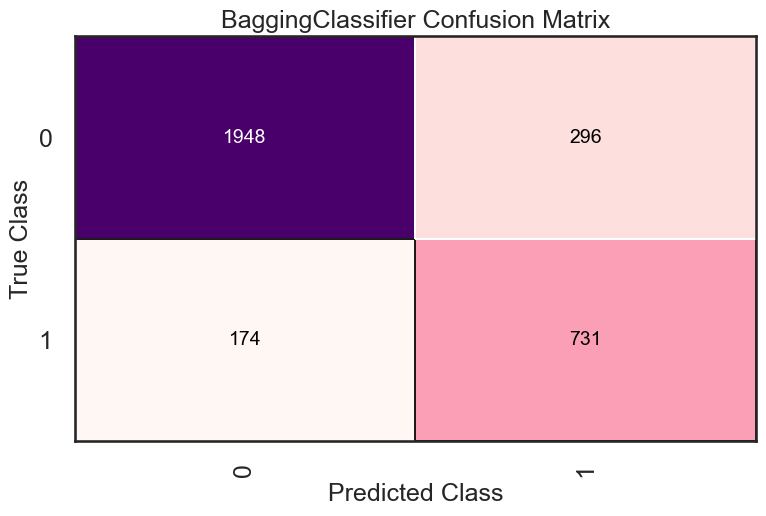

In [33]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    cm = ConfusionMatrix(best_model,  classes=[0, 1], cmap='RdPu') #percent=True, 
    cm.score(X_test, y_test)
    for label in cm.ax.texts:
        label.set_size(14)
    # cm.poof()
    cm.show(FIGURE_PATH + 'confusion matrix_before threshold moving.png'); #clear_figure=True


# Hyperparameter Tuning of Threshold for Interpreting Probabilities

C:\Users\yvett\anaconda3\envs\employee-attrition-python\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


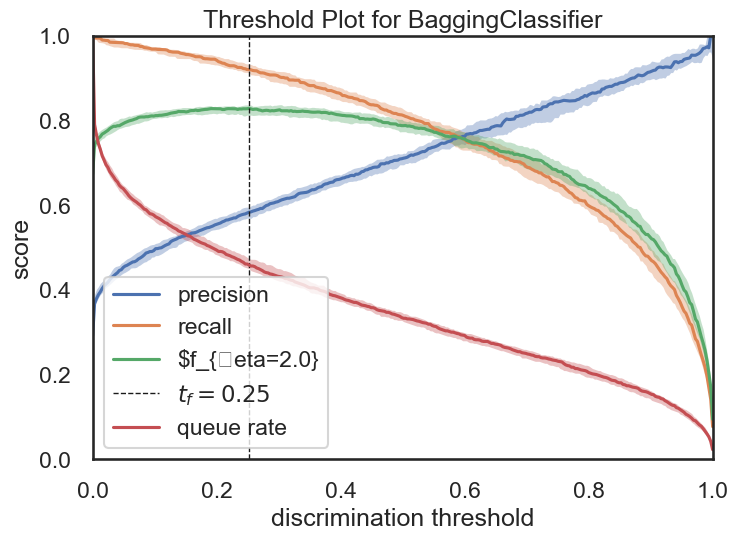

In [34]:
visualizer = DiscriminationThreshold(best_model, fbeta=2.0, quantiles=np.array([0.25, 0.5, 0.75]), random_state=RANDOM_STATE)

visualizer.fit(X_train, y_train)
visualizer.show();  

In [35]:
best_threshold = visualizer.thresholds_[visualizer.cv_scores_[visualizer.argmax].argmax()];
best_threshold
best_model_opt = imblearn.pipeline.make_pipeline(*best_model[:-1],Thresholder(best_model[3], best_threshold))
best_model_opt.fit(X_train, y_train)

# Predict the model with the pca testing dataset
y_pred_opt = best_model_opt.predict(X_test)

0.2523076923076923

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  [2, 6, 8]),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['0',
                                                                              '1'],
                                                                             ['2',
                                                                              '3',
                                                                              '4',
                                                                              '5'],
                                                                             ['low',
                                                                              'medium',
                                                                              'high'],
                                                                             ['0',
                                                                              '1'],
                                                                             ['2',
                                                                              '3',
                                                                              '4',
                                                                              '5',
                                                                              '6',
                                                                              '7',
                                                                              '8',
                                                                              '9',
                                                                              '10',
                                                                              '11',
                                                                              '12'],
                                                                             ['detractors',
                                                                              'passives',
                                                                              'promoters'],
                                                                             ['subpar '
                                                                              'performers',
                                                                              'solid '
                                                                              'performers'...
                                                   'review.group3']),
                                                 ('nom',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['department',
                                                   'avg_hrs_month.group3'])])),
                ('variancethreshold', VarianceThreshold(threshold=0)),
                ('svmsmote', SVMSMOTE(random_state=2021)),
                ('thresholder',
                 Thresholder(model=BaggingClassifier(estimator=DecisionTreeClassifier(),
                                                     n_estimators=1000,
                                                     random_state=2021),
                             threshold=0.2523076923076923))])

## evaluate best estimator with tuned threshold

In [36]:
# Classification Report
print('\nClassification Report (After Threshold Moving): \n\n', classification_report(y_test, y_pred_opt, target_names=targ_names, digits=3))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

# Model evaluation
scores = evaluate_model(X_test, y_test, best_model_opt)
# summarize performance
print('Mean F2: %.3f ± %.3f' % (np.mean(scores), std(scores)))


Classification Report (After Threshold Moving): 

               precision    recall  f1-score   support

  stayed (0)      0.957     0.734     0.831      2244
    left (1)      0.582     0.918     0.713       905

    accuracy                          0.787      3149
   macro avg      0.770     0.826     0.772      3149
weighted avg      0.849     0.787     0.797      3149


TN = 1648, FP = 596, FN = 74, TP = 831


Mean F2: 0.820 ± 0.027


0.8507462686567164

<AxesSubplot: title={'center': 'Thresholder Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

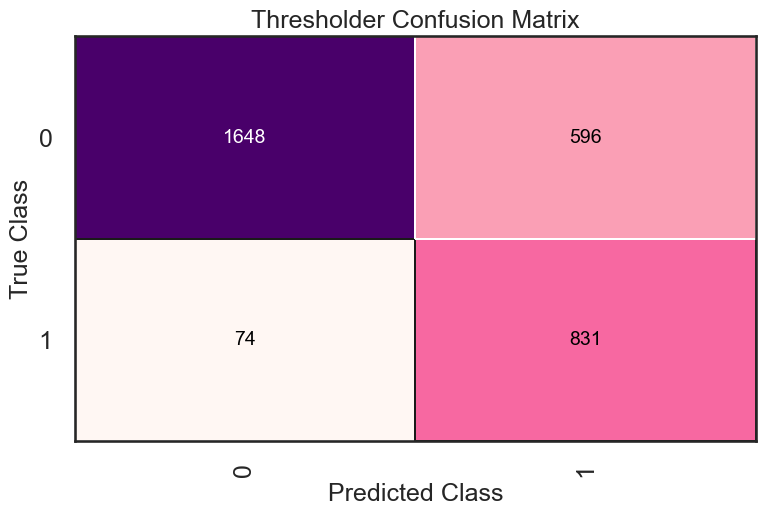

In [37]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    cm = ConfusionMatrix(best_model_opt,  classes=[0, 1], cmap='RdPu') #percent=True, 
    cm.score(X_test, y_test)
    for label in cm.ax.texts:
        label.set_size(14)
    # cm.poof()
    cm.show(FIGURE_PATH + 'confusion matrix_after threshold moving.png'); #clear_figure=True

#### Observation

# Post Modeling Analysis

## Features Most Predictive of Employee Attrition

In [38]:
from sklearn.inspection import permutation_importance
perm_importance_result_train = permutation_importance(best_model_opt, X_train, y_train, random_state=RANDOM_STATE)

In [39]:
# perm_importance_result_train

In [40]:
def plot_feature_importances(perm_importance_result, feat_name):
    """ bar plot the feature importance """
    fig, ax = plt.subplots()

    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices])
    ax.set_yticks(range(len(indices)))
    ax.set_title("Permutation importance")
    
    tmp = np.array(feat_name)
    _ = ax.set_yticklabels(tmp[indices])

ppl_fts = pipe[:-1]
ppl_fts.fit(X_train, y_train)
features = ppl_fts.get_feature_names_out()
features

Pipeline(steps=[('p',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  [2, 6, 8]),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['0',
                                                                              '1'],
                                                                             ['2',
                                                                              '3',
                                                                              '4',
                                                                              '5'],
                                                                             ['low',
                                                                              'medium',
                                                                              'high'],
                                                                             ['0',
                                                                              '1'],
                                                                             ['2',
                                                                              '3',
                                                                              '4',
                                                                              '5',
                                                                              '6',
                                                                              '7',
                                                                              '8',
                                                                              '9',
                                                                              '10',
                                                                              '11',
                                                                              '12'],
                                                                             ['detractors',
                                                                              'passives',
                                                                              'promoters'],
                                                                             ['subpar '
                                                                              'performers',
                                                                              'solid '
                                                                              'performers',
                                                                              'high '
                                                                              'performers']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['promoted', 'projects',
                                                   'salary', 'bonus', 'tenure',
                                                   'satisfaction.group3',
                                                   'review.group3']),
                                                 ('nom',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['department',
                                                   'avg_hrs_month.group3'])])),
                ('selector', VarianceThreshold()),
                ('r', SVMSMOTE(random_state=2021))])

array(['num__review', 'num__satisfaction', 'num__avg_hrs_month',
       'ord__promoted', 'ord__projects', 'ord__salary', 'ord__bonus',
       'ord__satisfaction.group3', 'ord__review.group3',
       'nom__department_IT', 'nom__department_admin',
       'nom__department_engineering', 'nom__department_finance',
       'nom__department_logistics', 'nom__department_marketing',
       'nom__department_operations', 'nom__department_retail',
       'nom__department_sales', 'nom__department_support',
       'nom__avg_hrs_month.group3_long-hour workers',
       'nom__avg_hrs_month.group3_short-hour workers'], dtype=object)

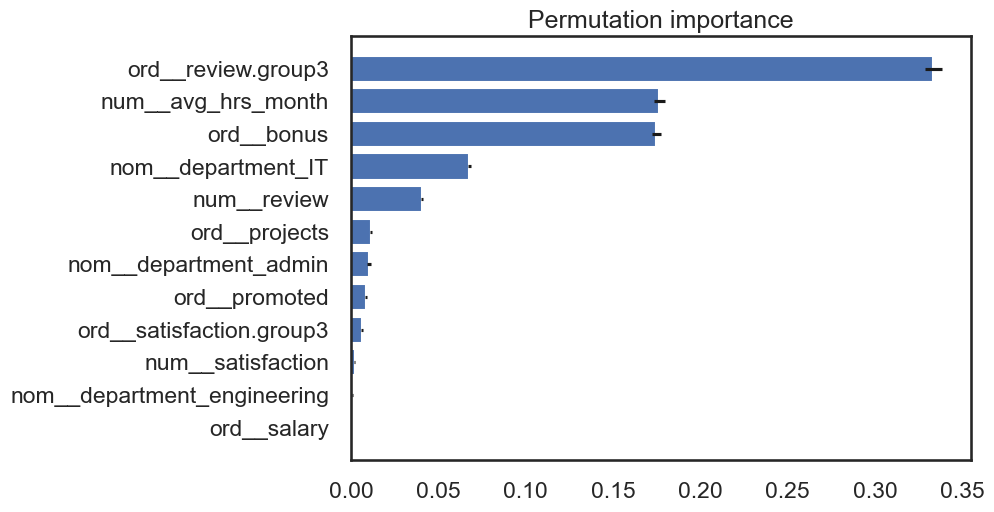

In [41]:
plot_feature_importances(perm_importance_result_train, features)

## Strategy Recommendations to Manage Employee Attrition

In [42]:
features

array(['num__review', 'num__satisfaction', 'num__avg_hrs_month',
       'ord__promoted', 'ord__projects', 'ord__salary', 'ord__bonus',
       'ord__satisfaction.group3', 'ord__review.group3',
       'nom__department_IT', 'nom__department_admin',
       'nom__department_engineering', 'nom__department_finance',
       'nom__department_logistics', 'nom__department_marketing',
       'nom__department_operations', 'nom__department_retail',
       'nom__department_sales', 'nom__department_support',
       'nom__avg_hrs_month.group3_long-hour workers',
       'nom__avg_hrs_month.group3_short-hour workers'], dtype=object)

In [43]:
indices = perm_importance_result_train['importances_mean'].argsort()
feature_importances=perm_importance_result_train['importances_mean'][indices]
tmp = np.array(features)
feature_names=tmp[indices]

In [44]:
feature_importances_sorted = sorted(zip(map(lambda x:round (x,3), feature_importances), feature_names), reverse=True);feature_importances_sorted

[(0.334, 'ord__review.group3'),
 (0.176, 'num__avg_hrs_month'),
 (0.175, 'ord__bonus'),
 (0.068, 'nom__department_IT'),
 (0.04, 'num__review'),
 (0.011, 'ord__projects'),
 (0.01, 'nom__department_admin'),
 (0.009, 'ord__promoted'),
 (0.006, 'ord__satisfaction.group3'),
 (0.002, 'num__satisfaction'),
 (0.001, 'nom__department_engineering'),
 (0.0, 'ord__salary')]

In [45]:
importance_table = pd.DataFrame(feature_importances_sorted, columns=['importance score', 'feature'])
importance_table['feature_raw'] = importance_table['feature'].str.split('__', expand=True)[1]; importance_table

,importance score,feature,feature_raw
0,0.33,ord__review.group3,review.group3
1,0.18,num__avg_hrs_month,avg_hrs_month
2,0.17,ord__bonus,bonus
3,0.07,nom__department_IT,department_IT
4,0.04,num__review,review
5,0.01,ord__projects,projects
6,0.01,nom__department_admin,department_admin
7,0.01,ord__promoted,promoted
8,0.01,ord__satisfaction.group3,satisfaction.group3
9,0.00,num__satisfaction,satisfaction


In [46]:
importance_table = importance_table.set_index(['importance score'])
importance_table = importance_table.reset_index()
importance_table

,importance score,feature,feature_raw
0,0.33,ord__review.group3,review.group3
1,0.18,num__avg_hrs_month,avg_hrs_month
2,0.17,ord__bonus,bonus
3,0.07,nom__department_IT,department_IT
4,0.04,num__review,review
5,0.01,ord__projects,projects
6,0.01,nom__department_admin,department_admin
7,0.01,ord__promoted,promoted
8,0.01,ord__satisfaction.group3,satisfaction.group3
9,0.00,num__satisfaction,satisfaction


In [47]:
importance_table['positive'] = np.where(importance_table['importance score'] > 0.01, 'yes', 'no')
importance_table.head(2)

,importance score,feature,feature_raw,positive
0,0.33,ord__review.group3,review.group3,yes
1,0.18,num__avg_hrs_month,avg_hrs_month,yes


In [48]:
importance_table_strategy = importance_table[(importance_table['positive'] == 'yes')]
importance_table_strategy

,importance score,feature,feature_raw,positive
0,0.33,ord__review.group3,review.group3,yes
1,0.18,num__avg_hrs_month,avg_hrs_month,yes
2,0.17,ord__bonus,bonus,yes
3,0.07,nom__department_IT,department_IT,yes
4,0.04,num__review,review,yes
5,0.01,ord__projects,projects,yes


### features contributions plot

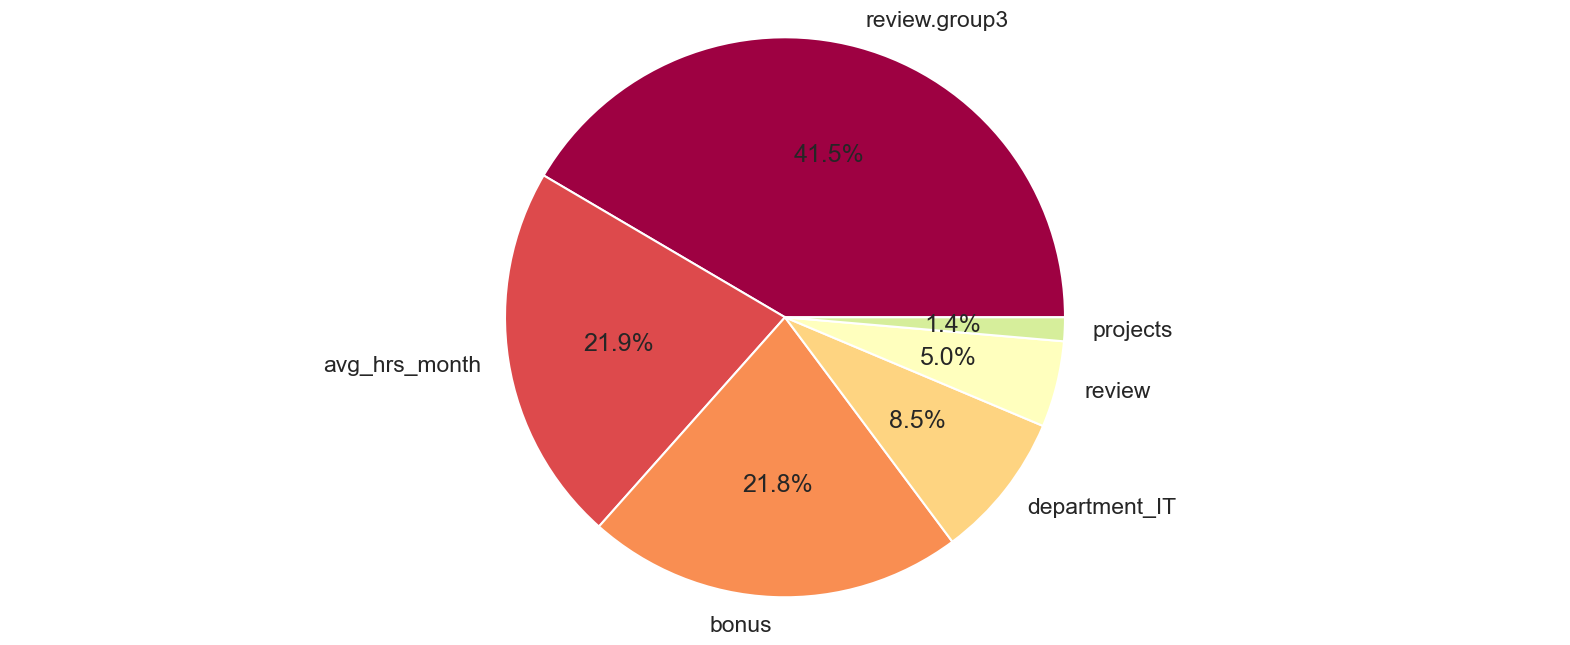

In [49]:
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 9)]

plt.figure(figsize=(20,8))
plt.pie(importance_table_strategy['importance score'], labels=importance_table_strategy['feature_raw'], autopct='%1.1f%%', shadow=False, colors=colors)
plt.axis('equal')
# plt.tight_layout()
# plt.savefig(FIGURE_PATH + 'feature importance.png', bbox_inches='tight')
plt.show();

# Export

## Final Model

In [50]:
joblib.dump(best_model_opt, MODELS_PATH + 'employee_attrition_model_v1_20230115.joblib')

['../models/employee_attrition_model_v1_20230115.joblib']